In [15]:
import requests
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

from power.ml_ops.data import get_pv_data, clean_pv_data, get_data_with_cache
from power.ml_ops.model import model_yesterday
from power.ml_ops.registry import load_model
from datetime import datetime, timedelta

from pathlib import Path
from power.params import *

In [2]:
model = load_model()

data_processed_cache_path = Path(LOCAL_DATA_PATH).joinpath("processed", f"processed_pv.csv")
query = f"""
    SELECT *
    FROM {GCP_PROJECT}.{BQ_DATASET}.processed_pv
    ORDER BY utc_time
"""
data_pv_clean = get_data_with_cache(
    gcp_project=GCP_PROJECT,
    query=query,
    cache_path=data_processed_cache_path,
    data_has_header=True
    )

# input_date = "2012-09-10 00:00:00"


Load latest model from local registry...

Load latest model from disk...


2024-03-10 08:43:08.928405: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_2_grad/concat/split_2/split_dim' with dtype int32
	 [[{{node gradients/split_2_grad/concat/split_2/split_dim}}]]
2024-03-10 08:43:08.937003: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_grad/concat/split/split_dim' with dtype int32
	 [[{{node gradients/split_grad/concat/split/split_dim}}]]
2024-03-10 08:43:08.942423: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You mus

✅ Model loaded from local disk

Load data from local CSV...
✅ Data loaded, with shape (376944, 3)


In [3]:
input_prediction_date = "2019-12-10 00:00:00"
# make api call
base_url = "http://127.0.0.1:8000"


# model
params_model ={
    'input_date':input_prediction_date,
    'n_days': 2,
    'power_source': 'pv'
    }

endpoint_model = "/baseline_yesterday"
url_model= f"{base_url}{endpoint_model}"
response_model = requests.get(url_model, params_model).json()

# baseline
params_baseline ={
    'input_date':input_prediction_date,
    'n_days': 2,
    'power_source': 'pv'
    }

endpoint_baseline = "/baseline_yesterday"
url_baseline= f"{base_url}{endpoint_baseline}"
response_baseline = requests.get(url_baseline, params_baseline).json()


# data
params_data ={
    'input_date':input_prediction_date,
    'n_days': 10,
    'power_source': 'pv'
    }

endpoint_data = "/extract_data"
url_data = f"{base_url}{endpoint_data}"
response_data = requests.get(url_data, params_data).json()


In [4]:
def predict_baseline_yesterday(input_date: str):
    data = data_pv_clean[data_pv_clean['utc_time'] < input_date][-24:]
    values = data.electricity.to_list()
    return {input_date: values}

# predict_baseline_yesterday(input_prediction_date)

In [5]:
def extract_pv_data(input_date: str, n_days=10):
    """
    Returns the power data for the n_days before the input date
    Also returns the power data for the following day
    """
    n_rows = 24 * n_days
    days_before = data_pv_clean[data_pv_clean['utc_time'] < input_date] \
                                        ['electricity'][-n_rows:].to_list()
    day_after = data_pv_clean[data_pv_clean['utc_time'] >= input_date] \
                                        ['electricity'][:24].to_list()


    extracted_data = {
        'days_before':days_before,
        'day_after':day_after
        }

    return {input_date: extracted_data}

# extract_pv_data(input_prediction_date)

In [6]:
def predict(input_date: str, n_days=2):
    pv_data_clean = data_pv_clean
    X_pred = pv_data_clean[pv_data_clean['utc_time'] < input_date][-48:]

    return {'dataframe to predict': X_pred.electricity.to_list()}

# predict(input_prediction_date)

In [12]:
baseline_data = response_data.get(input_prediction_date)

In [14]:
x_data = baseline_data['days_before']['date']
y_data = baseline_data['days_before']['power_source']
y_data

[0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.003,
 0.032,
 0.069,
 0.088,
 0.073,
 0.047,
 0.013,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.004,
 0.047,
 0.098,
 0.115,
 0.111,
 0.086,
 0.049,
 0.011,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.02,
 0.039,
 0.047,
 0.053,
 0.038,
 0.017,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.004,
 0.038,
 0.06,
 0.091,
 0.075,
 0.081,
 0.021,
 0.004,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.012,
 0.073,
 0.182,
 0.305,
 0.32,
 0.427,
 0.318,
 0.115,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.028,
 0.181,
 0.479,
 0.592,
 0.606,
 0.543,
 0.389,
 0.149,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.003,

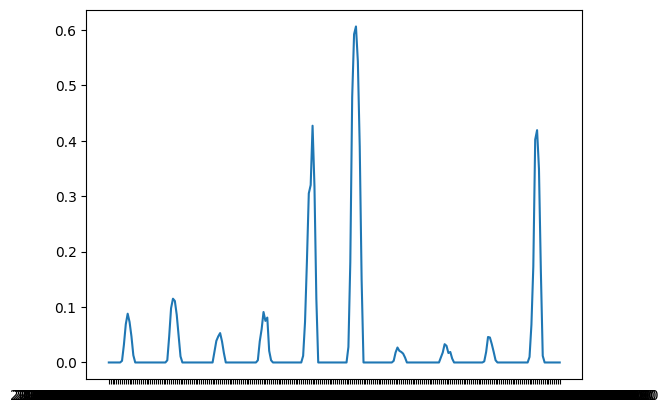

In [16]:
plt.plot(x_data, y_data);